In [1]:
### run the script from the figures_code directory
import sys
os.chdir('../')
import pandas as pd
import numpy as np
import os
import seaborn as sns
import scipy.io as sio
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt

from importlib import reload
from matplotlib.patches import Rectangle

from functions import parsing
from functions import data_processing as dp
from functions import lib_table_operations as lto
from functions import params

## (A) Msn2 library scatters - H3 vs Msn2

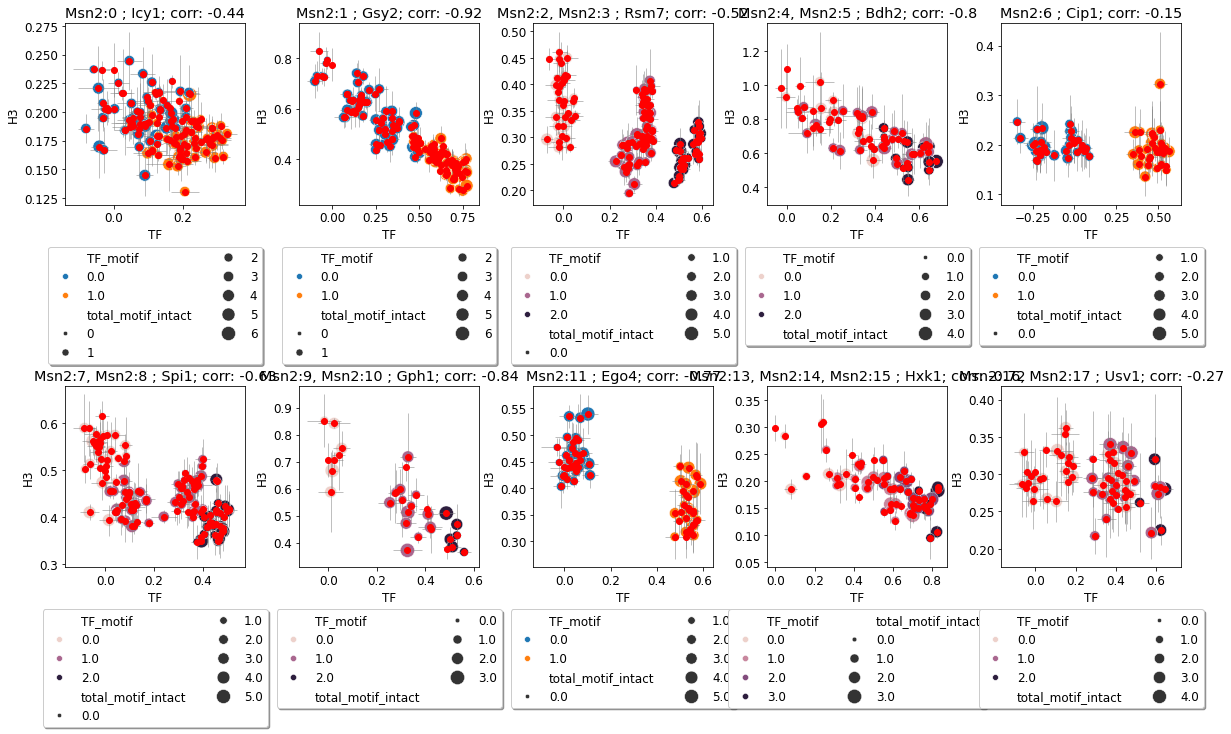

In [15]:
exp_num_h3 = '31'
exp_num_tf = '13'
tp='180'
tf = 'Msn2'
h3_libs = [f.split('_')[1] for f in dp.find_tf_files('H3')]
msn2_libs = [f.split('_')[1] for f in dp.find_tf_files('Msn2')]
h3_msn2_libs = np.intersect1d(h3_libs,msn2_libs) # Msn2 libraries measured in H3-MNase

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
plt.subplots_adjust(hspace = 1)
plt.subplots_adjust(wspace = 0.3)

for lib_i, lib_num in enumerate(h3_msn2_libs):
    lib_num_int = int(lib_num)
    curr_ax = axes.ravel()[lib_i]
    lib_info = dp.get_lib_info(lib_num)
    gene = lib_info['gene'].upper()
    wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
    mut_var_seq = lto.get_mut_var(lib_num)
   
    # normlize nucs
    norm_0_h3 = lto.norm_without_biorep_mean('H3', lib_num, exp_num_h3, 0, occ=None) # normlize data
    norm_wt = norm_0_h3 - (norm_0_h3.loc[wt_var_seq])    
    norm_nuc = 1/2**norm_wt* params.LIB_NUC_NORM.query("Lib_num == @lib_num_int")['Ratio'].values[0]
    mean_res_h3 = dp.mean_over_bio_reps(norm_nuc)[tp]      ##################
    sem_h3 = dp.sem_over_bio_reps(norm_nuc)[tp]

    #normzlize tf
    norm_uncut_tf = lto.norm_without_biorep_mean(tf, lib_num, exp_num_tf, None, occ=True) # normlize data
    mean_res_tf = dp.mean_over_bio_reps(norm_uncut_tf)[tp]      ##################
    sem_tf = dp.sem_over_bio_reps(norm_uncut_tf)[tp]

    #combine H3 and TF data to df
    exp_comp_df = pd.concat([mean_res_tf, mean_res_h3],axis=1)
    exp_comp_df.columns = ['TF', 'H3'] 
    exp_comp_df['H3_sem'] = sem_h3
    exp_comp_df['TF_sem'] = sem_tf
        
    tf_pos = lto.get_tf_mot_pos(tf,lib_num) #get tf library positions
    seqs = exp_comp_df.index # library sequences
    all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences spli
    tf_intact_motif_seqs = np.zeros((len(seqs),1))
    pos_in_mot = 1
    if lib_num == '88':
        tf_pos = np.arange(0,4,3)
        pos_in_mot = 2
        for pos in tf_pos:
            tf_pos_in_seq = np.array([''.join(seq) for seq in all_seqs_split[:,pos:pos+pos_in_mot]]) == wt_var_seq[pos:pos+pos_in_mot]
            tf_intact_motif_seqs[tf_pos_in_seq] += 1
    else:
        for pos in tf_pos:#iterate over tf postion
            tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos]] += 1 # count number of tf motif in seq 
    exp_comp_df['TF_motif'] = tf_intact_motif_seqs

    intact_pos = np.zeros((len(seqs),len(list(wt_var_seq))))
    for pos_i, pos in enumerate(list(wt_var_seq)):
        intact_pos[:,pos_i] = all_seqs_split[:,pos_i] == pos
    exp_comp_df['total_motif_intact'] = np.reshape(np.sum(intact_pos, axis=1), (len(seqs),1)) - tf_intact_motif_seqs

    tf_ranks=[]
    lib_int = int(lib_num)
    for i, row in params.LIB_MOT_RANK.query("lib==@lib_int and tf==@tf").iterrows():
        tf_ranks.append(row['tf'] + ':' + str(i))
    ', '.join(tf_ranks)

    corr_val = str(np.round(exp_comp_df.corr().values[1][0],2))

    #### scatters comparing TF to H3
    sns.scatterplot(data=exp_comp_df, x='TF', y='H3', hue='TF_motif',
                    size='total_motif_intact',sizes=(20,200), ax=curr_ax)
    curr_ax.errorbar(exp_comp_df['TF'], exp_comp_df['H3'], xerr=exp_comp_df['TF_sem'],
                 yerr=exp_comp_df['H3_sem'],ecolor='grey',elinewidth=0.5, color='r', fmt='o')

    curr_ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=True, ncol=2)

    curr_ax.set_title(', '.join(tf_ranks) + ' ; ' + lib_info['gene'] + '; corr: ' + corr_val)


## (B) Correlation between H3 and Msn2

<AxesSubplot: >

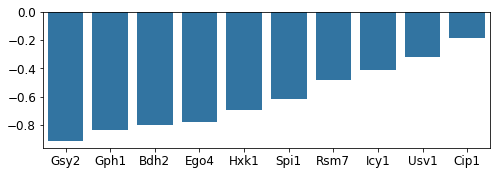

In [17]:
tp = '180'
strains = ['Msn2', 'H3']
exps = ['13', '31']
corr_dict = {}
for lib_num in h3_msn2_libs:
    lib_data = pd.DataFrame() 
    for i, strain in enumerate(strains): 
        norm_res = lto.norm_res_data(strain, lib_num, exps[i], norm_to=0)
        relevant_cols = norm_res.columns[norm_res.columns.str.contains(tp)]
        norm_res = norm_res[relevant_cols].mean(axis=1).to_frame()
        norm_res.columns = [strain]
        lib_data = pd.concat([lib_data, norm_res], axis=1)
    corr_val = lib_data.corr().values[0,1]
    corr_dict[dp.get_lib_info(lib_num)['gene']] = corr_val

corr_dict = dict(sorted(corr_dict.items(), key=lambda item: item[1]))

f, ax = plt.subplots(1,1,figsize=(8, 2.5))
sns.barplot(corr_dict)